# Time Series Forecasting of Sales

### Keywords
- Analytical Framework
- Time Series Data Visualisation
- Time Series Forecasting
- Comparison of ETS Model vs. (Seasonal) ARIMA

## Table of Contents

<ul>
<li><a href="#Intro">1. Introduction</a></li>
<li><a href="#Preparation">2. Data Preparation</a></li>
<li><a href="#Exploration">3. Data Exploration</a></li>
    - 3.1. Visualize the Time Series<br>
    - 3.2. Determine Trend, Seasonal, and Error components<br>
<li><a href="#Analysis">4. Data Analysis</a></li>
    - 4.1. Build the Forecasting Models  <br>
    - 4.2. Validate the Models <br>
    - 4.3. Forecast  <br>
<li><a href="#Conclusion">5. Conclusion</a></li>
</ul>

<a id='Intro'></a>
## 1. Introduction

This analysis is the project for **"Time Series Forecasting"**
The purpose of the project is to forecast monthly sales data for a video game company, in order to help plan out the supply with demand for the company's video games.

Many businesses have to be on point when it comes to ordering supplies to meet the demand of its customers. An overestimation of demand leads to bloated inventory and high costs. Underestimating demand means many valued customers won't get the products they want. Therefore, for this project I was tasked to forecast monthly sales data in order to synchronize supply with demand, aid in decision making that will help build a competitive infrastructure and measure company performance. Throughout the analysis I will provide a forecast for the next 4 months of sales and report your findings.

<a id='Preparation'></a>
## 2. Data Preparation

In [12]:
# Import the relevant libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)

In [13]:
# Load the provided dataset
sales_data = pd.read_excel('monthly-sales.xlsx')

In [14]:
sales_data.head(), sales_data.tail() # Glance at the dataset(1)

(     Month  Monthly Sales
 0  2008-01         154000
 1  2008-02          96000
 2  2008-03          73000
 3  2008-04          51000
 4  2008-05          53000,
       Month  Monthly Sales
 64  2013-05         231000
 65  2013-06         271000
 66  2013-07         329000
 67  2013-08         401000
 68  2013-09         553000)

In [15]:
sales_data.info() ## Glance at the dataset(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Month          69 non-null     object
 1   Monthly Sales  69 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


> Initial findings of the time series contain the 4 key characteristics of time series data. The series is over a continuous time interval, of sequential measurements, across that interval, using equal spacing between every two consecutive measurements and each time unit within the time interval has at most one data point. The data collected is composed of monthly sales data from Janunary 2008 and to September 2013. For the sake of convenience, I set the time interval as the index. <br><br>
**Train & Test records:**
In preparation for construction of a predictive models, I have filtered out the last 4 records (from 2013-06 to 2013-09), as a holdout sample so that I can check the accuracy of my model to forecast predicted values against the actual values.

In [16]:
sales_data = sales_data.set_index('Month')  # Set the time variable as an index
sales_data.index =  pd.date_range(start=sales_data.index[0] , periods=len(sales_data), freq='MS')

In [17]:
sales_data_train = sales_data.iloc[:-4, :] # Train set
sales_data_test = sales_data.iloc[-4:, :] # Test set for validation

sales_data_train.index = pd.date_range(start=sales_data_train.index[0] , periods=len(sales_data_train), freq='MS')
sales_data_test.index = pd.date_range(start=sales_data_test.index[0] , periods=len(sales_data_test), freq='MS')

In [18]:
sales_data_train.shape, sales_data_test.shape

((65, 1), (4, 1))

In [19]:
sales_data_test['Monthly Sales']

,Monthly Sales
2013-06-01,271000
2013-07-01,329000
2013-08-01,401000
2013-09-01,553000


<a id='Exploration'></a>
## 3. Data Exploration

- Visualize the Time Series
- Determine Trend, Seasonal, and Error components

### 3.1. Visualize the Time Series

Text(0.5, 1.0, 'Time Series Plots of Sales Amount')

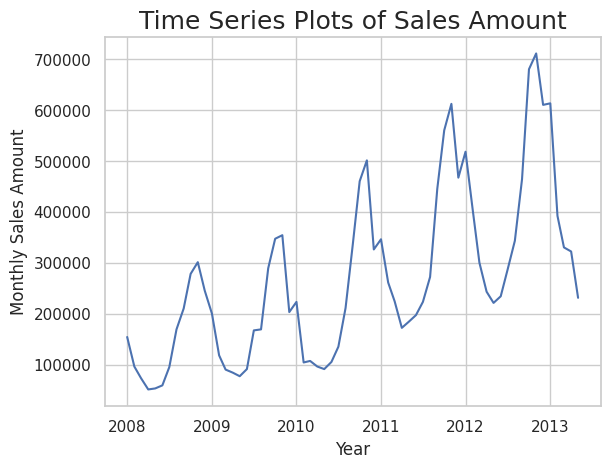

In [20]:
fig, ax = plt.subplots()
ax.plot(sales_data_train.index, sales_data_train['Monthly Sales'])
ax.set_ylabel('Monthly Sales Amount')
ax.set_xlabel('Year')
ax.set_title('Time Series Plots of Sales Amount', size=18)

> Time Series Plots of Sales Amount shows general movement of sales data. The monthly sales amount of the company is generally increasing over the time. For selecting forecasting methods, the time series can be broken down into systematic and unsystematic components. A time series is composed of three systematic components including 'level', 'trend', 'seasonality', and one non-systematic component called 'noise'. The four components can be either **additively** or **multiplicatively** combined. The components in our dataset can be visually evaluated through the decomposition plots in the next section. <br>  [Reference - Time Series Data](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

### 3.2. Determine Trend, Seasonal, and Error components

Text(0.5, 0, 'Year')

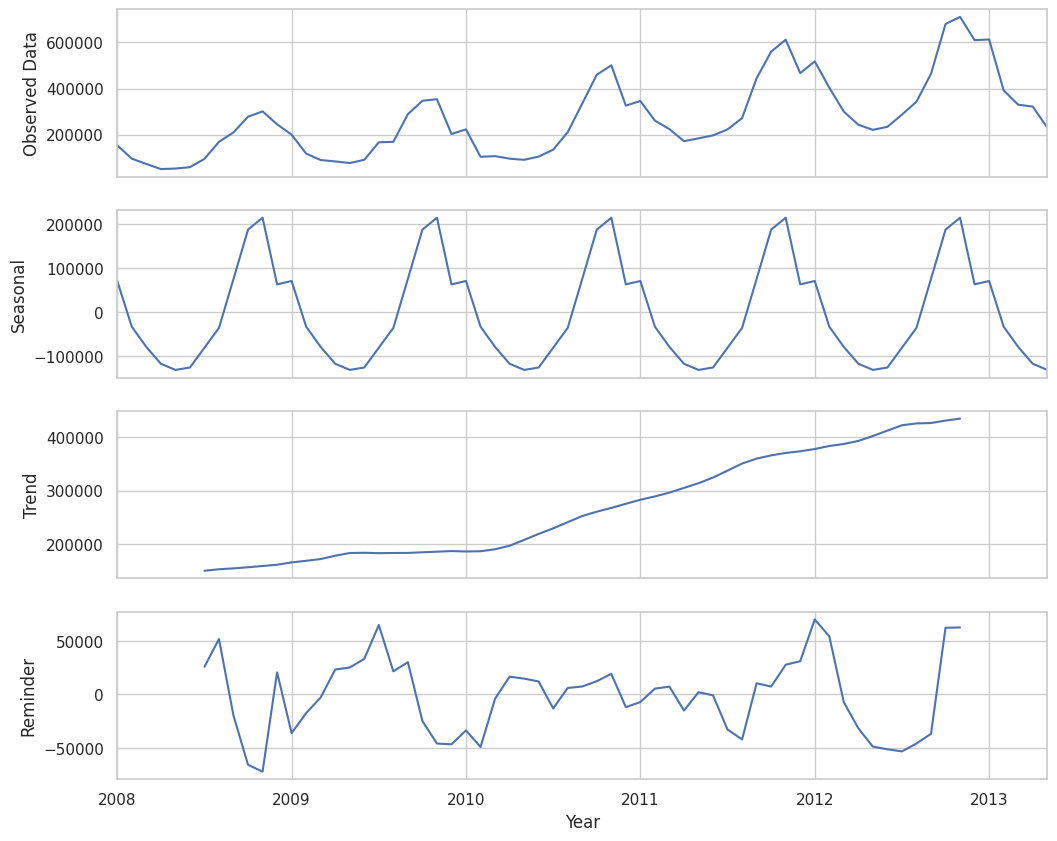

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(sales_data_train['Monthly Sales'], model='additive', period=12)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10), sharex= True)
res.observed.plot(ax=ax1)
ax1.set_ylabel('Observed Data')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.trend.plot(ax=ax3)
ax3.set_ylabel('Trend')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Reminder')

plt.xlabel("Year")

> The decomposition plot shows our time series broken down into its three components: trend, seasonal and the error. Each of these components makes up our time series and helps us confirm what we saw in our initial time series plot.
>- The Trend line is confirmed that there is an upward trending.
>- The Seasonality subplot shows that the regularly occurring spike in sales each year changes in magnitude, ever so slightly. Our dataset definitely contains seasonality, and this suggests that any ARIMA models used for
analysis will need seasonal differencing. The change in magnitude suggests that any ETS models will use a multiplicative method in the seasonal component.
>- The Error plot of the series presents a fluctuations between large and smaller errors as the time series goes on. Since the fluctuations are not consistent in magnitude then we will apply error in a multiplicative manner for any ETS models.

<a id='Analysis'></a>
## 4. Data Analysis
<br>
<li><a href="#build">4.1. Build the Forecasting Models</a></li>
<li><a href="#holdout">4.2. Predict the Holdout Sample</a></li>
<li><a href="#forecast">4.3. Forecast for the next 4 months of sales</a></li>

<a id='build'></a>
### 4.1. Build the Forecasting Models

In the previous section, I analyzed the decomposition graphs to inform forecasting models on the business problem. In this section, I determine the appropriate measurements to apply to the ETS model and the (Seasonal) ARIMA. Then I compare both models based on in-sample errors. <br><br>

<li><a href="#ETS">4.1.1. ETS Models</a></li>
<li><a href="#ARIMA">4.1.2. Seasonal ARIMA</a></li>


### 4.1.1. ETS Models

ETS stands for Error, Trend, and Seasonality, and are the three inputs in ETS models. From the decomposition plot, we can obtain the necessary information to define the terms for the ETS model.
- The **Trend** line exhibits linear behavior so we will use an **additive** method.
- The **Seasonality** changes in magnitude each year so a **multiplicative** method seems necessary.
- The **Error changes** in magnitude as the series goes along so a **multiplicative** method will be used.<br>
This leaves us with an **ETS(M, A, M)** model.

In [22]:
# Import the relevant libraries
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [23]:
sales_data_train = pd.Series(sales_data_train['Monthly Sales']).astype('float64')
ets_model = ETSModel(sales_data_train, error='mul', trend='add', seasonal = 'mul',
                     damped_trend=True, seasonal_periods=12, initial_level=sales_data_train.values.mean(), freq='MS')
ets_fitted = ets_model.fit()

In [24]:
print(ets_fitted.summary())

                                 ETS Results                                  
Dep. Variable:          Monthly Sales   No. Observations:                   65
Model:                      ETS(MAdM)   Log Likelihood                -758.979
Date:                Fri, 05 Dec 2025   AIC                           1555.958
Time:                        07:38:57   BIC                           1597.272
Sample:                    01-01-2008   HQIC                          1572.259
                         - 05-01-2013   Scale                            0.017
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999        nan        nan        nan         nan         nan
smoothing_trend      9.999e-05      0.047      0.002      0.998      -0.091       0.091
smoothing_season

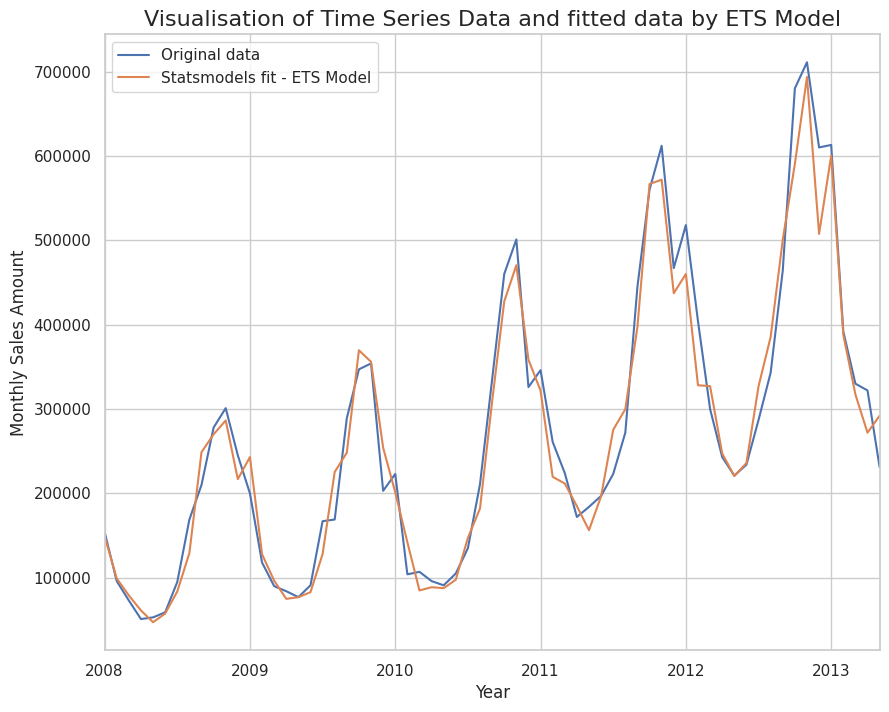

In [25]:
plt.figure(figsize=(10,8))
sales_data_train.plot(label='Original data')
ets_fitted.fittedvalues.plot(label='Statsmodels fit - ETS Model')
plt.title('Visualisation of Time Series Data and fitted data by ETS Model' , fontsize=16)
plt.ylabel("Monthly Sales Amount");
plt.xlabel("Year")
plt.legend();

In [26]:
pred_ets= ets_fitted.fittedvalues # Store the predicted values based on ETS model as "pred_ets"

### Evaluating In-Sample Accuracy (ETS Models)
> Now, I describe the in-sample errors based on ETS models. The in-sample error measures give us a look at how well our model is able to predict future values. Among the various Error Terms, I chose:
>- RMSE (Rooted Mean Squared Error)
>- MAE (Mean Absolute Error)
>- MAPE (Mean Absolute Percentage Error)
>- MASE (Mean Absolute Scaled Error) <br>

> For some error terms, I directly use the existing functions from the scikit-learn library. Otherwise, I calculate the error terms for a list of predictions. [Reference: Time Series Forecasting Performance Measures With Python](https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/#:~:text=Mean%20forecast%20error%20is%20calculated,of%20the%20forecast%20error%20values.&text=A%20mean%20forecast%20error%20value,also%20called%20the%20forecast%20bias.)


In [27]:
expected_ets = sales_data_train.values
predicted_ets = pred_ets.values

In [28]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error

def mean_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) / y_true * 100)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def running_diff(arr, N):
    return np.array([arr[i] - arr[i-N] for i in range(N, len(arr))])

def mean_absolute_scaled_error(training_series, testing_series, prediction_series):
    errors_mean = np.abs(testing_series - prediction_series ).mean()
    d = np.abs(running_diff(training_series, 12) ).mean()
    return errors_mean/d

mse_ets  = mean_squared_error(expected_ets, predicted_ets)
rmse_ets = sqrt(mse_ets)
mae_ets  = mean_absolute_error(expected_ets, predicted_ets)
mpe_ets  = mean_percentage_error(expected_ets, predicted_ets)
mape_ets = mean_absolute_percentage_error(expected_ets, predicted_ets)
mase_ets = mean_absolute_scaled_error(expected_ets, expected_ets, predicted_ets)

print('In-Sample Error Measures of ETS Models:')
print('')
print('- RMSE: %.2f' % rmse_ets)
print('- MAE : %.2f' % mae_ets)
print('- MPE : %.2f' % mpe_ets)
print('- MAPE: %.2f' % mape_ets)
print('- MASE: %.2f' % mase_ets)

In-Sample Error Measures of ETS Models:

- RMSE: 33983.11
- MAE : 25891.55
- MPE : 0.63
- MAPE: 10.57
- MASE: 0.38


- **Scale-dependent errors:** <br>
The two most commonly used scale-dependent measures are the absolute errors(MAE) or squared errors(RMSE). When comparing forecast methods applied to one time series, or to several time series with the same units, the MAE is popular, because it is easy to both understand and compute. A forecast method that minimises the MAE will lead to forecasts of the median, while minimising the RMSE will lead to forecasts of the mean. Consequently, the RMSE is also widely used, despite being more difficult to interpret. [Reference](https://otexts.com/fpp2/accuracy.html)

- **Percentage errors:** <br>
ercentage errors have the advantage of being unit-free, and so are frequently used to compare forecast performances between data sets. The most commonly used measure is MAPE. [Reference](https://otexts.com/fpp2/accuracy.html)

- **Scaled errors:** <br>
Scaled errors were proposed by Hyndman & Koehler (2006) as an alternative to using percentage errors when comparing forecast accuracy across series with different units. They proposed scaling the errors based on the training MAE from a simple forecast method. A scaled error is less than 1, if it arises from a better forecast than the average naïve forecast computed on the training data. Conversely, it is greater than 1 if the forecast is worse than the average naïve forecast computed on the training data. [Reference](https://otexts.com/fpp2/accuracy.html)

> Two key measures we have to check are the RMSE, which shows the in-sample standard deviation, and the MASE which can be used to compare forecasts of different models. We can see that the value of RMSE is about 34000 units around the mean. The MASE shows a fairly strong forecast at .38 with its value falling well below the generic 1.00, the commonly accepted MASE threshold for model accuracy.

<a id='ARIMA'></a>
### 4.1.2. Seasonal ARIMA

In Time Series Analysis, we should start the analysis with a "stationary" data. make the data stationary. As the decomposition plots exhibit, the provided dataset seems to have seasonality and linear Trend. Augmented Dickey Fuller test reminds us the fact that the given data is not stationary.

In [29]:
# Augmented Dickey Fuller test
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(sales_data_train.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.613050
p-value: 0.997896


By differencing data points, I make the time series stationary.

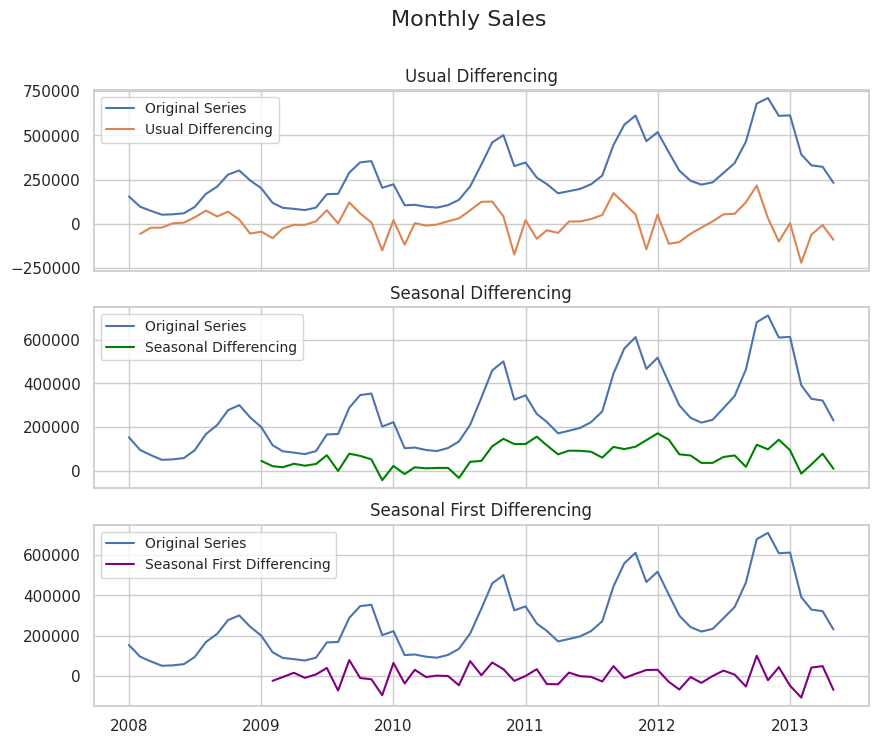

In [30]:
# Plot
fig, axes = plt.subplots(3, 1, figsize=(10,8), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(sales_data_train, label='Original Series')
axes[0].plot(sales_data_train.diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)
sales_data_diff = sales_data_train.diff(1)

# Seasinal Dei
axes[1].plot(sales_data_train, label='Original Series')
axes[1].plot(sales_data_train.diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
axes[1].legend(loc='upper left', fontsize=10)

# Seasinal first differencing
axes[2].plot(sales_data_train, label='Original Series')
axes[2].plot(sales_data_diff.diff(12), label='Seasonal First Differencing', color='purple')
axes[2].set_title('Seasonal First Differencing')
axes[2].legend(loc='upper left', fontsize=10)
plt.suptitle('Monthly Sales', fontsize=16)
plt.show()

In [31]:
# Augmented Dickey Fuller test for Seasonal First Differencing Data
seasonal_first_differencing = sales_data_diff.diff(12)
result_seasonal_first_diff = adfuller(seasonal_first_differencing.dropna())
print('ADF Statistic for Seasonal First Differencing: %.4f' % result_seasonal_first_diff[0])
print('p-value for Seasonal First Differencing: %.4f' % result_seasonal_first_diff[1])

ADF Statistic for Seasonal First Differencing: -9.4464
p-value for Seasonal First Differencing: 0.0000


> As you can see from the third plot, the original time series data is changed a stationary data after seasonal first differencing. This fact can be also confirmed by the p-value of Augmented Dickey Fuller test. Taking the seasonal first difference has now made our data stationary. Next, I find the optimal parameters based on the Time Series ACF and PACF graphs. <br>
[Reference](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

#### i. Time Series ACF and PACF  

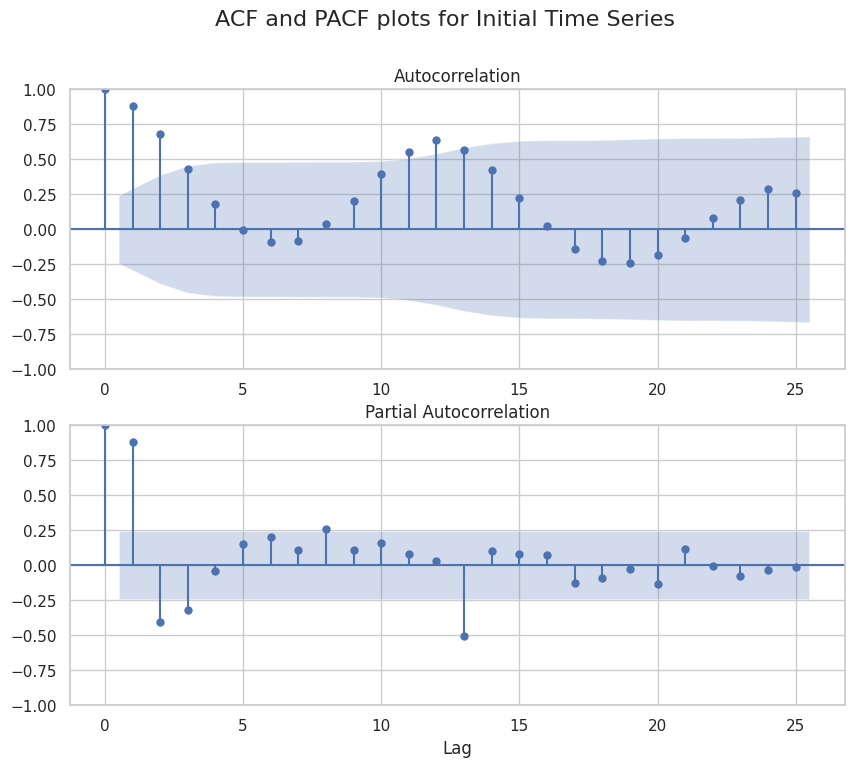

In [32]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig=plot_acf(sales_data_train,  lags=25, ax=ax1)

ax2 = fig.add_subplot(212)
fig=plot_pacf(sales_data_train, lags=25,  ax=ax2)

plt.xlabel('Lag')
plt.suptitle('ACF and PACF plots for Initial Time Series', fontsize=16)
plt.show()

> The ACF presents slowly decaying serial correlations towards 0 with increases at the seasonal lags. Since serial correlation is high I will need to seasonally difference the series.

#### ii. Seasonal Difference ACF and PACF

/tmp/ipython-input-2908361813.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.array([arr[i] - arr[i-N] for i in range(N, len(arr))])


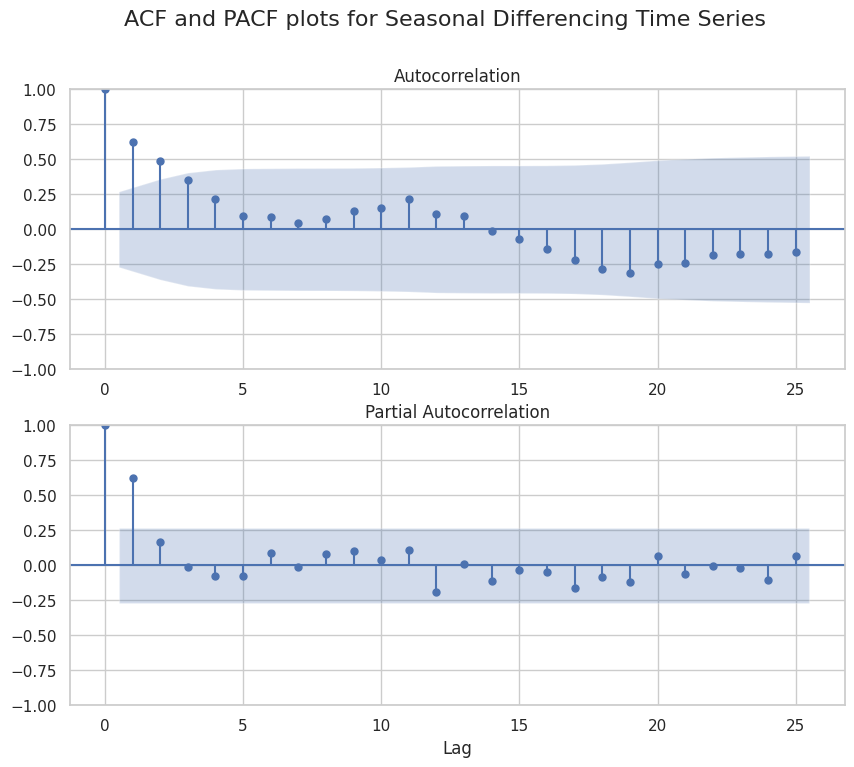

In [33]:
seasonal_diff = running_diff(sales_data_train, 12)

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig=plot_acf(seasonal_diff, lags=25,  ax=ax1)

ax2 = fig.add_subplot(212)
fig=plot_pacf(seasonal_diff, lags=25,  ax=ax2)

plt.xlabel('Lag')
plt.suptitle('ACF and PACF plots for Seasonal Differencing Time Series', fontsize=16)
plt.show()

> The seasonal difference presents similar ACF and PACF patterns as the initial plots, without differencing, only slightly less correlated. In order to remove correlation we will need to difference further.

#### iii. Seasonal First Difference ACF and PACF

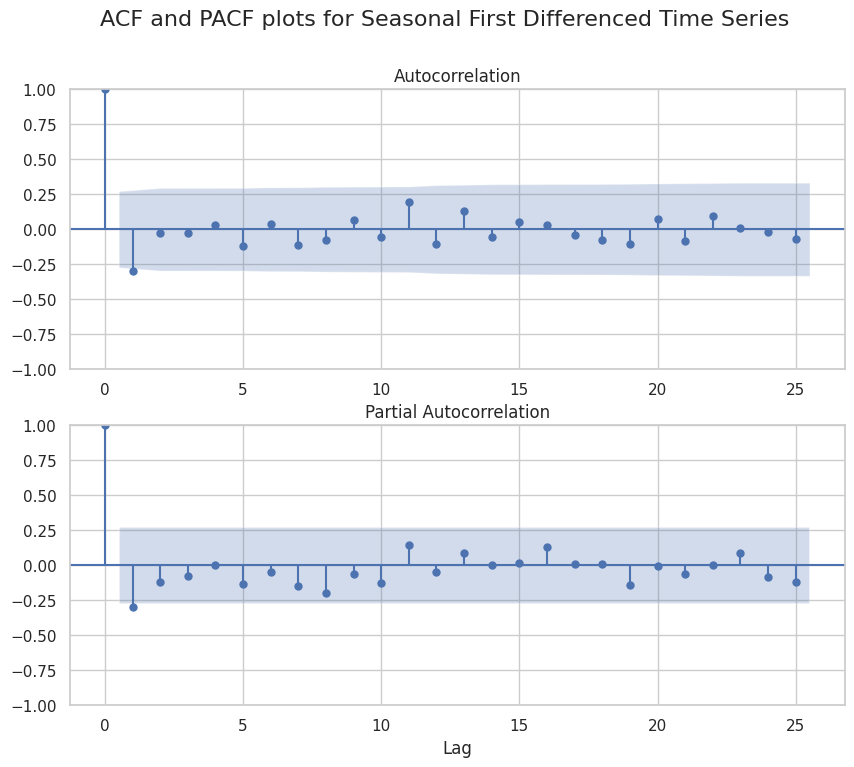

In [34]:
seasonal_diff_1 = running_diff(seasonal_diff, 1)

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig=plot_acf(seasonal_diff_1, lags=25,  ax=ax1)

ax2 = fig.add_subplot(212)
fig=plot_pacf(seasonal_diff_1, lags=25,  ax=ax2)

plt.xlabel('Lag')
plt.suptitle('ACF and PACF plots for Seasonal First Differenced Time Series', fontsize=16)
plt.show()

- The seasonal first difference of the series has removed most of the significant lags from the ACF and PACF. It seems no more need for further differencing. The remaining correlation can be considered for using autoregressive and moving average terms. Therefore, the differencing terms will be d(1) and D(1).
- The ACF plot shows a strong negative correlation at lag-1 which is confirmed in the PACF. This suggests an MA(1) model since there is only 1 significant lag. The seasonal lags (lag 12, 24, etc.) in the ACF and PACF do not have any significant correlation so there will be no need for seasonal autoregressive or moving average terms.
- Therefore, the model terms for my ARIMA model are: **ARIMA(0, 1, 1)(0, 1, 0)[12]**. Note that the ACF and PACF results for the ARIMA(0, 1, 1)(0, 1, 0)[12] model shows no significantly correlated lags suggesting no need for adding additional AR() or MA() terms.

#### iv. Define the Seasonal ARIMA model

In [35]:
# Define model
model_sarima = sm.tsa.statespace.SARIMAX(endog = sales_data_train,
                                         order=(0, 1, 1), seasonal_order=(0,1,0,12),
                                         trend = 't', freq = 'MS',
                                         seasonal_periods =12,
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
# FIt Model
sarima_fitted = model_sarima.fit(dynamic=False)
print(sarima_fitted.summary())

                                      SARIMAX Results                                      
Dep. Variable:                       Monthly Sales   No. Observations:                   65
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -602.879
Date:                             Fri, 05 Dec 2025   AIC                           1211.757
Time:                                     07:39:08   BIC                           1217.493
Sample:                                 01-01-2008   HQIC                          1213.942
                                      - 05-01-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        -22.1131     83.683     -0.264      0.792    -186.128     141.902
ma.L1         -0.3884      

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_periods']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dynamic. After release 0.14, this will raise.
  warnings.warn(


#### v. Plot Residual Errors

Plotting residuals make us ensure there are no patterns. In other words, we can check for constant mean and variance of residuals.

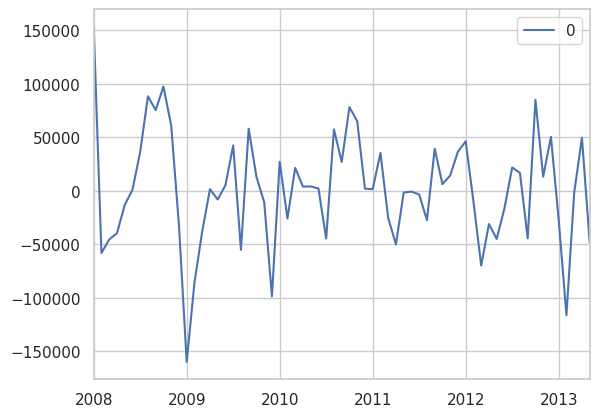

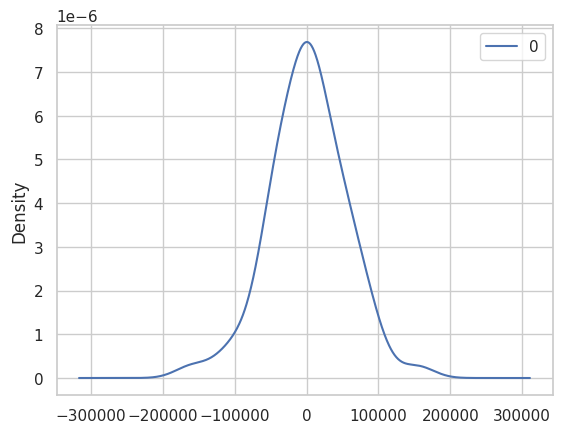

                   0
count      65.000000
mean     1666.863535
std     53192.284723
min   -159843.212915
25%    -30967.052455
50%      1602.428306
75%     36504.350419
max    154000.000000


In [36]:
residuals = pd.DataFrame(sarima_fitted.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

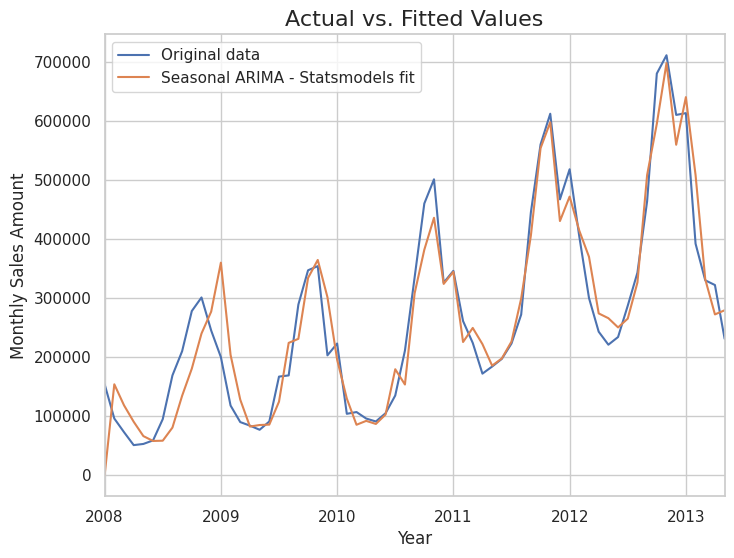

In [37]:
# Compare the Original Time Series and Fitted values
sales_data_train.plot(label='Original data',figsize=(8,6))
sarima_fitted.fittedvalues.plot(label='Seasonal ARIMA - Statsmodels fit')
plt.ylabel("Monthly Sales Amount");
plt.xlabel("Year")
plt.title('Actual vs. Fitted Values', fontsize= 16)
plt.legend();

#### vi. Evaluating In-Sample Accuracy (Seasonal ARIMA)

In [38]:
predicted_sarima = sarima_fitted.predict().values
expected_sarima = sales_data_train.values

mse_sarima  = mean_squared_error(expected_sarima, predicted_sarima)
rmse_sarima = sqrt(mse_sarima)
mae_sarima  = mean_absolute_error(expected_sarima, predicted_sarima)
mpe_sarima  = mean_percentage_error(expected_sarima, predicted_sarima)
mape_sarima = mean_absolute_percentage_error(expected_sarima, predicted_sarima)
mase_sarima = mean_absolute_scaled_error(expected_sarima, expected_sarima, predicted_sarima)

print('In-Sample Error Measures of Seasonal ARIMA Models:')
print(' ')
print('- RMSE : %f' % rmse_sarima)
print('- MAE  : %f' % mae_sarima)
print('- MPE  : %f' % mpe_sarima)
print('- MAPE : %f' % mape_sarima)
print('- MASE : %f' % mase_sarima)


In-Sample Error Measures of Seasonal ARIMA Models:
 
- RMSE : 52807.840920
- MAE  : 39576.055365
- MPE  : -3.478534
- MAPE : 20.196629
- MASE : 0.577355


> So far, I have analysed the training part of time series data using ETS Models and Seasonal ARIMA. Then I compared the performance of each model with In-Sample Error Measures such as RMSE, MAPE and MASE. When comparing the two in-sample error measures we used, the ETS model does have a much  narrower standard deviation(RMSE). Though the MASE value of ETS model is lower than that of Seasonal ARIMA, both are below 1.00, the generally accepted MASE threshold for model accuracy. <br>
Next, I compare the prediction performance of both models using holdout samples.

<a id='holdout'></a>
### 4.2. Predict the Holdout Sample

In [39]:
# ETS Model for Validation
sales_data = pd.Series(sales_data['Monthly Sales']).astype('float64')
ets_model_holdout = ETSModel(sales_data, error='mul', trend='add', seasonal = 'mul',
                             damped_trend=True, seasonal_periods=12,
                             initial_level=sales_data_train.values.mean(), freq='MS')
ets_fitted_holdout = ets_model_holdout.fit()

In [40]:
# Predicted values for holdout samples (test samples) - ETS model
ets_fitted_holdout.predict()[-4:]

,0
2013-06-01,250577.106556
2013-07-01,371513.423008
2013-08-01,435705.133884
2013-09-01,580161.684503


In [41]:
# Seasonal ARIMA Model for Validation
model_sarima_holdout = sm.tsa.statespace.SARIMAX(endog = sales_data,
                                                 order=(0, 1, 1), seasonal_order=(0,1,0,12),
                                                 trend = 't', freq = 'MS',
                                                 seasonal_periods =12,
                                                 enforce_stationarity=False,
                                                 enforce_invertibility=False)
sarima_fitted_holdout = model_sarima_holdout.fit(dynamic=False)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_periods']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dynamic. After release 0.14, this will raise.
  warnings.warn(


In [42]:
# Predicted values for holdout samples (test samples) - Seasonal ARIMA model
sarima_fitted_holdout.predict()[-4:]

,predicted_mean
2013-06-01,265077.673473
2013-07-01,322917.680752
2013-08-01,383874.673687
2013-09-01,516710.170399


In [43]:
holdout_results = pd.DataFrame({'actual': sales_data_test['Monthly Sales'],
                                 'predicted_ETS': ets_fitted_holdout.predict()[-4:].values,
                                 'predicted_ARIMA': sarima_fitted_holdout.predict()[-4:].values },
                               index = sales_data_test.index)
holdout_results

,actual,predicted_ETS,predicted_ARIMA
2013-06-01,271000,250577.106556,265077.673473
2013-07-01,329000,371513.423008,322917.680752
2013-08-01,401000,435705.133884,383874.673687
2013-09-01,553000,580161.684503,516710.170399


#### Holdout Sample Prediction Error Comparison

In [44]:
sales_data_train

,Monthly Sales
2008-01-01,154000.0
2008-02-01,96000.0
2008-03-01,73000.0
2008-04-01,51000.0
2008-05-01,53000.0
...,...
2013-01-01,613000.0
2013-02-01,392000.0
2013-03-01,330000.0
2013-04-01,322000.0


In [45]:
# Holdout-Sample Errors Comparison
# ETS Model
mse_ets_hos  = mean_squared_error(sales_data_test['Monthly Sales'], holdout_results['predicted_ETS'])
rmse_ets_hos = sqrt(mse_ets_hos)
mae_ets_hos  = mean_absolute_error(sales_data_test['Monthly Sales'], holdout_results['predicted_ETS'])
mpe_ets_hos  = mean_percentage_error(sales_data_test['Monthly Sales'], holdout_results['predicted_ETS'])
mape_ets_hos = mean_absolute_percentage_error(sales_data_test['Monthly Sales'], holdout_results['predicted_ETS'])
mase_ets_hos = mean_absolute_scaled_error(sales_data_train.values, sales_data_test['Monthly Sales'], holdout_results['predicted_ETS'])

print('Holdout-Sample Error Measures of ETS Models:')
print(' ')
print('- RMSE : %.3f' % rmse_ets_hos)
print('- MAE  : %.3f' % mae_ets_hos)
print('- MPE  : %.3f' % mpe_ets_hos)
print('- MAPE : %.3f' % mape_ets_hos)
print('- MASE : %.3f' % mase_ets_hos)
print(' ')
# (Seasonal) ARIMA Model
mse_sarima_hos  = mean_squared_error(sales_data_test['Monthly Sales'], holdout_results['predicted_ARIMA'])
rmse_sarima_hos = sqrt(mse_sarima_hos)
mae_sarima_hos  = mean_absolute_error(sales_data_test['Monthly Sales'],  holdout_results['predicted_ARIMA'])
mpe_sarima_hos  = mean_percentage_error(sales_data_test['Monthly Sales'],  holdout_results['predicted_ARIMA'])
mape_sarima_hos = mean_absolute_percentage_error(sales_data_test['Monthly Sales'],  holdout_results['predicted_ARIMA'])
mase_sarima_hos = mean_absolute_scaled_error(sales_data_train.values, sales_data_test['Monthly Sales'],  holdout_results['predicted_ARIMA'])
print(' ')
print('Holdout-Sample Error Measures of Seasonal ARIMA Models:')
print(' ')
print('- RMSE : %.3f' % rmse_sarima_hos)
print('- MAE  : %.3f' % mae_sarima_hos)
print('- MPE  : %.3f' % mpe_sarima_hos)
print('- MAPE : %.3f' % mape_sarima_hos)
print('- MASE : %.3f' % mase_sarima_hos)

Holdout-Sample Error Measures of ETS Models:
 
- RMSE : 32274.948
- MAE  : 31200.784
- MPE  : -4.738
- MAPE : 8.506
- MASE : 0.455
 
 
Holdout-Sample Error Measures of Seasonal ARIMA Models:
 
- RMSE : 20507.908
- MAE  : 16354.950
- MPE  : 3.717
- MAPE : 3.717
- MASE : 0.239


> When looking at the model's ability to predict the holdout sample, we can recognize that the Seasonal ARIMA model shows better predictive performance in all metrics.

<a id='forecast'></a>
### 4.3. Forecast for the next 4 months of Sales

Previously, I concluded that the Seasonal ARIMA model shows better performance in terms of prediction. Now, I forecast for the next four-month sales using all the time series data based on the same Seasonal ARIMA model. First, I diagnose the stationarity of the whole time series data again. Then the forecast results are calculated using 95% and 80% confidence intervals.

In [46]:
# Seasonal ARIMA Model for Forecasting
model_sarima_final = sm.tsa.statespace.SARIMAX(sales_data, order=(0, 1, 1),
                                             seasonal_order=(0,1,0,12), trend = 't',
                                             seasonal_periods =12,
                                             enforce_stationarity=False, enforce_invertibility=False)
# FIt Model
sarima_fitted_final = model_sarima_final.fit(dynamic=False)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_periods']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dynamic. After release 0.14, this will raise.
  warnings.warn(


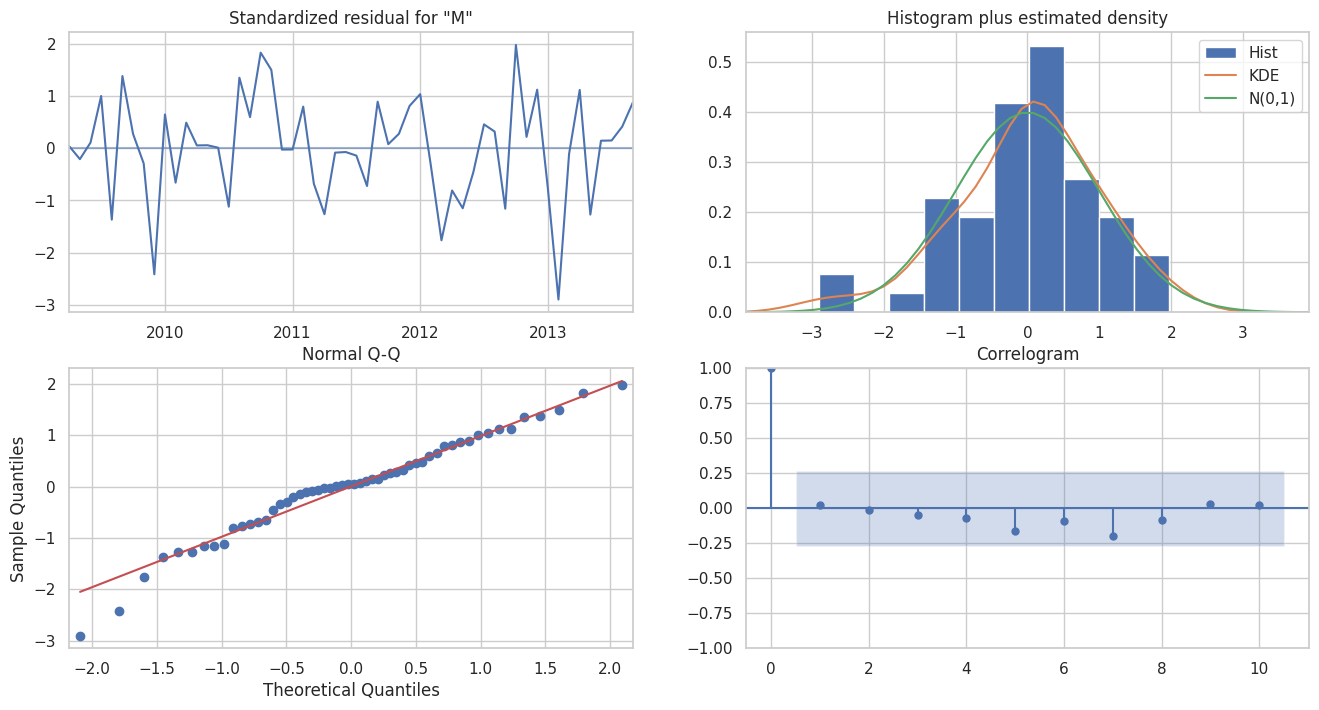

In [47]:
sarima_fitted_final.plot_diagnostics(figsize=(16, 8))
plt.show()

In [48]:
# Forecast the nest 4 periods of Sales Amount
fcast = sarima_fitted_final.get_forecast(4)
forecast_results = pd.DataFrame({'forecast_mean': fcast.predicted_mean,
                                 'forecast_high_95': fcast.conf_int(alpha= 0.05).iloc[:,1],
                                 'forecast_high_80': fcast.conf_int(alpha= 0.20).iloc[:,1],
                                 'forecast_low_80': fcast.conf_int(alpha= 0.20).iloc[:,0],
                                 'forecast_low_95': fcast.conf_int(alpha= 0.05).iloc[:,0],
                                })
forecast_results.index = pd.date_range(start=forecast_results.index[0] , periods=len(forecast_results), freq='MS')
forecast_results

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_periods']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


,forecast_mean,forecast_high_95,forecast_high_80,forecast_low_80,forecast_low_95
2013-10-01,756469.982843,837662.052684,809558.623775,703381.341911,675277.913002
2013-11-01,788700.836873,884287.127317,851201.352765,726200.320980,693114.546428
2013-12-01,688949.274531,797029.456049,759619.106692,618279.442370,580869.093013
2014-01-01,693215.295819,812487.724959,771203.345342,615227.246295,573942.866679


Text(0.5, 1.0, 'Actual and Forecast Values')

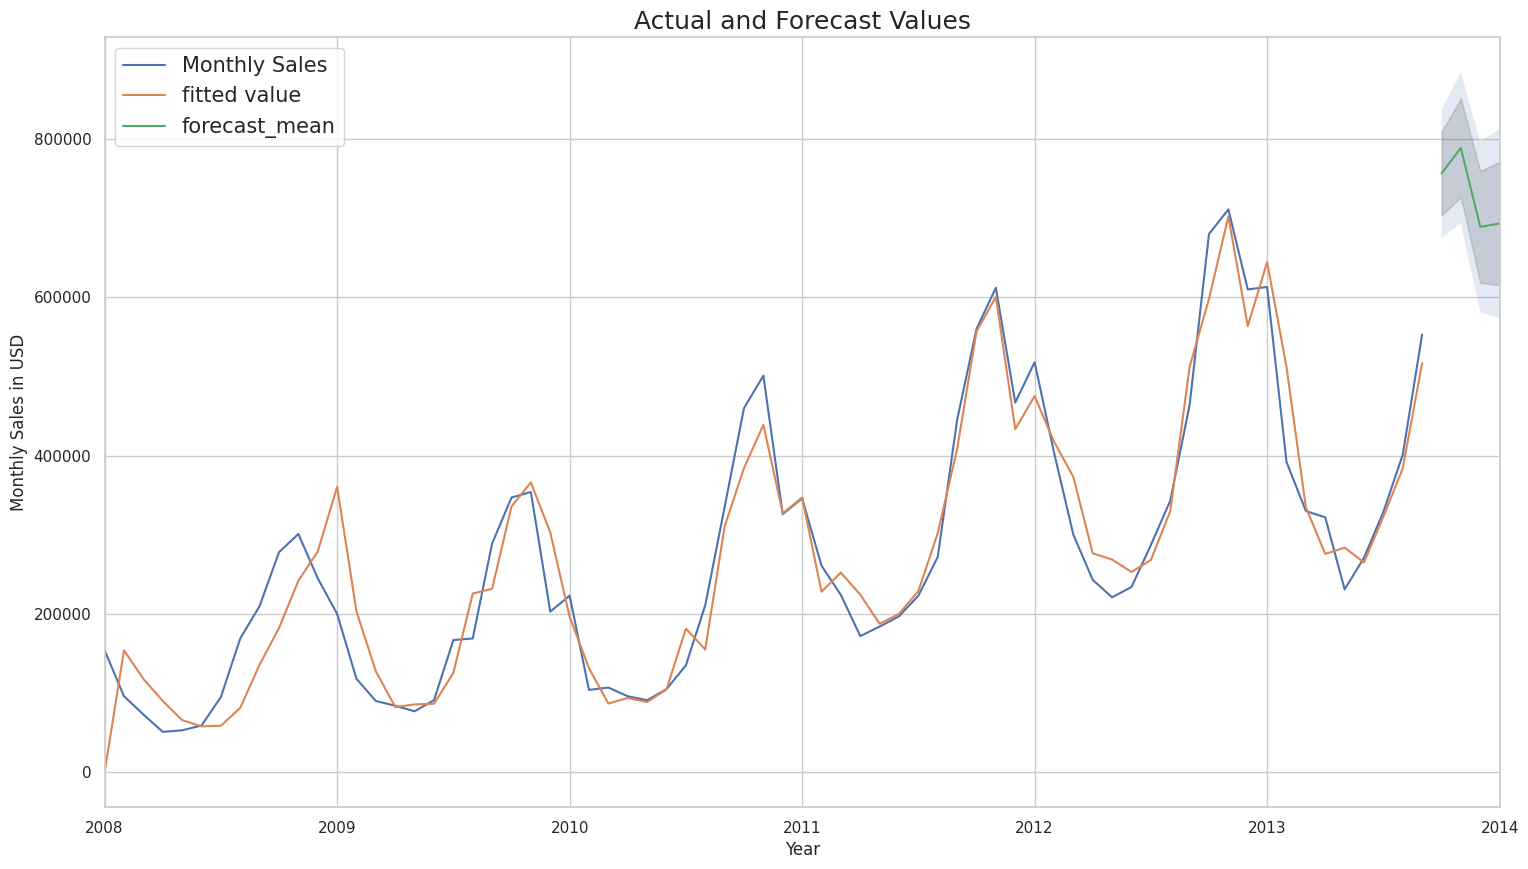

In [49]:
# Visualize the forecast results
sales_data.plot(figsize=(18,10))
sarima_fitted_final.fittedvalues.plot(label = 'fitted value')
forecast_results.forecast_mean.plot()
upper_series_80 = forecast_results.forecast_high_80
lower_series_80 = forecast_results.forecast_low_80
upper_series_95 = forecast_results.forecast_high_95
lower_series_95 = forecast_results.forecast_low_95

plt.fill_between(upper_series_80.index,
                 lower_series_80,
                 upper_series_80,
                 color='k', alpha=.15)

plt.fill_between(lower_series_95.index,
                 lower_series_95,
                 upper_series_95,
                 color= None, linestyle ='--', alpha=.15)
plt.legend(loc = 'upper left', fontsize =15)
plt.xlabel('Year')
plt.ylabel('Monthly Sales in USD')
plt.title('Actual and Forecast Values', fontsize = 18)

<a id='Conclusion'></a>
## Conclusion



> This analysis is mainly about forecasting for upcoming sales in a video game company. Firstly, I investigate and prepare the time series data. The provided data was appropriate to use time series models and I held out the last 4 periods of data points for validation. Then, I determined Trend, Seasonal and Error components in the data based on decomposition plots. After that, I analyse the data by applying the ARIMA and ETS models and describe the errors for both models. I compared the in-sample error measurements to both models and compare error measurements for the holdout sample in the forecast. Finally,I choose the best fitting model and forecast the next four periods.
<br>
